<a href="https://colab.research.google.com/github/nat-christoforou/Dog-Breed-Identification/blob/master/Dog_Breed_Identification_01_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breed Identification 01

In this first Notebook I am going to use a pre-trained Xception model in order to determine the breed of each dog in the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import glob
from functools import partial

In [2]:
from google.colab import drive
# Accessing My Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load and prepare the training data

In [3]:
INPUT_PATH = "drive/My Drive/Dog Breed Identification/"
TRAIN_ROOT_PATH = INPUT_PATH + "train/"
TEST_ROOT_PATH = INPUT_PATH + "test/"

In [4]:
# read the labels dataset
labels = pd.read_csv(INPUT_PATH + "labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
labels.shape

(10222, 2)

In [6]:
# training settings
BATCH_SIZE = 32
DATASET_SIZE = len(labels["breed"])
NUM_CLASSES = labels["breed"].nunique()

In [7]:
# tf.data.Dataset settings
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [8]:
# Map dog breeds to numbers
label_to_num = dict(zip(sorted(list(labels["breed"].unique())),
                        range(NUM_CLASSES)))

In [9]:
# Split the training set to training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(labels["id"],
                                                labels["breed"], 
                                                stratify=labels["breed"],
                                                test_size=0.2,
                                                random_state=42)

In [10]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((8177,), (2045,), (8177,), (2045,))

In [11]:
def get_image_path(image_id, extension=".jpg"):
    """
    Given the id of an image return its directory path
    """
    return TRAIN_ROOT_PATH + image_id + extension

def load_and_decode_image(path, channels=3):
    """
    Read a JPEG-encoded image from path and decode it to a uint8 tensor
    """
    image = tf.io.read_file(path)
    return tf.image.decode_jpeg(image, channels=channels)

def get_label_num(label_name):
    """
    Represent labels with numbers 
    """
    return label_to_num.get(label_name)

def get_label_from_num(num):
    """
    Get label from numerical representation 
    """
    return list(label_to_num.keys())[list(label_to_num.values()).index(num)]

In [12]:
def get_pair_ds(images, labels):
    """
    Load images and labels to datasets
    """
    path_ds = tf.data.Dataset.from_tensor_slices(list(map(get_image_path, images.values)))
    image_ds = path_ds.map(load_and_decode_image, num_parallel_calls=AUTOTUNE)
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(list(map(get_label_num, labels.values)), tf.int64))
    return image_ds, label_ds

def apply_ds(image_ds, label_ds):
    """
    Combine image and label datasets
    """
    ds = tf.data.Dataset.zip((image_ds, label_ds))
    return ds

# load the training and validation images to datasets
train_ds = apply_ds(*get_pair_ds(x_train, y_train))
valid_ds = apply_ds(*get_pair_ds(x_valid, y_valid))

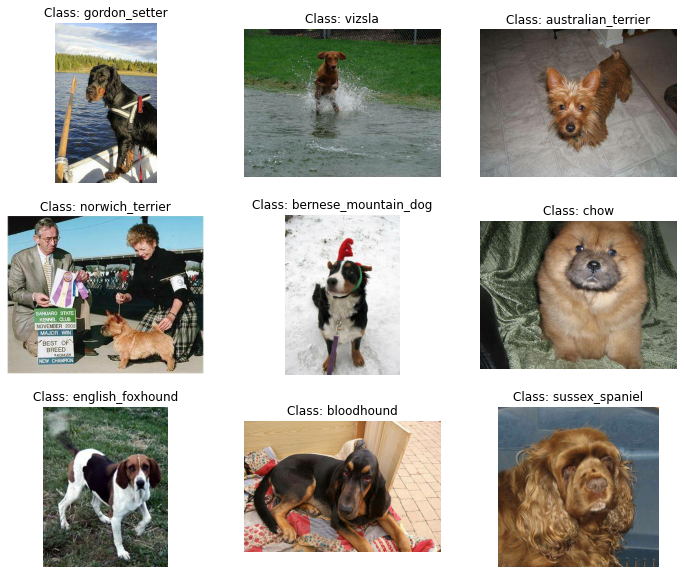

In [13]:
# plot the first 9 images of the training dataset
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_ds.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(get_label_from_num(label)))
    plt.axis("off")

plt.show()

In [14]:
# preprocessing functions
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, img_size=224, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [img_size, img_size])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [15]:
# suffle, preprocess (with some random transformations), batch and prefetch the training dataset
train_set = train_ds.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(BATCH_SIZE).prefetch(1)
# batch and prefetch the validation dataset
valid_set = valid_ds.map(preprocess).batch(BATCH_SIZE).prefetch(1)

### Train the Xception model

Now, I will load the Xception model, pretrained on ImageNet, excluding the top of the network. Specifically, I exclude the global average pooling layer and the dense output layer. Then, I will add my own global average pooling layer based on the output of the base_model, followed by a dense output layer with one unit per class, using the softmax activation function. Finally, I will create the keras model:

In [16]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(NUM_CLASSES, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

For the beginning of the training I will freeze the weights of the pretrained layers, and I will then compile and train the model. The loss I am using is the sparse_categorical_crossentropy because I have sparse labels, meaning that for each instance, there is just a target class index, from 0 to 119 in this case. 

In [17]:
# freeze weights of pretrained layers
for layer in base_model.layers:
    layer.trainable = False

# compile model
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

# train model
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * DATASET_SIZE / BATCH_SIZE),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * DATASET_SIZE / BATCH_SIZE),
                    epochs=5)

Epoch 1/5
239/239 [==============================] - 2342s 10s/step - loss: 1.2238 - accuracy: 0.7504 - val_loss: 1.0852 - val_accuracy: 0.7932
Epoch 2/5
239/239 [==============================] - 90s 378ms/step - loss: 0.5236 - accuracy: 0.8730 - val_loss: 0.8325 - val_accuracy: 0.8225
Epoch 3/5
239/239 [==============================] - 90s 378ms/step - loss: 0.3556 - accuracy: 0.8954 - val_loss: 0.7998 - val_accuracy: 0.8238
Epoch 4/5
239/239 [==============================] - 90s 377ms/step - loss: 0.2815 - accuracy: 0.9159 - val_loss: 0.7468 - val_accuracy: 0.8311
Epoch 5/5
239/239 [==============================] - 90s 378ms/step - loss: 0.2355 - accuracy: 0.9232 - val_loss: 0.7403 - val_accuracy: 0.8358


After training the model for a few epochs (5 in this case), the top layers are pretty well trained, and now we are ready to unfreeze all the layers and continue training. However, this time I will use a much lower learning rate to avoid damaging the pretrained weights.

In [18]:
# callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint("drive/My Drive/Dog Breed Identification/best_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8,
                                                  monitor="val_accuracy")
callbacks = [checkpoint_cb, early_stopping_cb]

In [19]:
# unfreeze weights 
for layer in base_model.layers:
    layer.trainable = True

# compile model with much lower learning rate
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"]) 

# train model with early stopping
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * DATASET_SIZE / BATCH_SIZE),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * DATASET_SIZE / BATCH_SIZE),
                    epochs=100, callbacks=callbacks)

Epoch 1/100
239/239 [==============================] - 314s 1s/step - loss: 0.6459 - accuracy: 0.8041 - val_loss: 0.9589 - val_accuracy: 0.7301
Epoch 2/100
239/239 [==============================] - 313s 1s/step - loss: 0.3251 - accuracy: 0.9001 - val_loss: 0.8977 - val_accuracy: 0.7646
Epoch 3/100
239/239 [==============================] - 313s 1s/step - loss: 0.1740 - accuracy: 0.9482 - val_loss: 0.7416 - val_accuracy: 0.7906
Epoch 4/100
239/239 [==============================] - 312s 1s/step - loss: 0.1192 - accuracy: 0.9655 - val_loss: 0.7804 - val_accuracy: 0.7952
Epoch 5/100
239/239 [==============================] - 313s 1s/step - loss: 0.0905 - accuracy: 0.9757 - val_loss: 0.7184 - val_accuracy: 0.8078
Epoch 6/100
239/239 [==============================] - 311s 1s/step - loss: 0.0655 - accuracy: 0.9842 - val_loss: 0.7311 - val_accuracy: 0.8085
Epoch 7/100
239/239 [==============================] - 313s 1s/step - loss: 0.0478 - accuracy: 0.9899 - val_loss: 0.6960 - val_accuracy:

In [20]:
# load the best model
best_model = keras.models.load_model("drive/My Drive/Dog Breed Identification/best_model.h5")

### Load and prepare the test data

In [21]:
# read the submission csv
submission_df = pd.read_csv(INPUT_PATH + "sample_submission.csv")
submission_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333

In [22]:
submission_df.shape

(10357, 121)

In [23]:
def get_image_path_test(image_id, extension=".jpg"):
    """
    Given the id of an image return its directory path
    """
    return TEST_ROOT_PATH + image_id + extension

def preprocess_test(image, img_size=224):
    resized_image = tf.image.resize(image, [img_size, img_size])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image

In [24]:
test_ids = submission_df['id']

# load and decode test images
path_ds = tf.data.Dataset.from_tensor_slices(list(map(get_image_path_test, test_ids.values)))
test_ds = path_ds.map(load_and_decode_image, num_parallel_calls=AUTOTUNE)

# preprocess, batch, and prefetch the test dataset
test_set = test_ds.map(preprocess_test).batch(BATCH_SIZE).prefetch(1)

### Predictions and submission to Kaggle

Now, having trained and loaded the best model we can use it to make predictions:

In [26]:
y_proba = best_model.predict(test_set)

In [27]:
for breed in labels['breed'].unique():
    submission_df[breed] = y_proba[:, get_label_num(breed)]

In [28]:
submission_df.head(2)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,2.695461e-07,4.305348e-06,1.051956e-07,1.772085e-07,4.020737e-08,4.118741e-08,5.602882e-08,3.779446e-08,8.056416e-08,5.179407e-08,1.155359e-07,1.016162e-07,3.370253e-08,1.850455e-05,6.066219e-08,2.482408e-07,1.150996e-07,2.403994e-08,2.221486e-07,5.225207e-07,1.303854e-07,2.480692e-07,4.320843e-06,1.129379e-07,9.274081e-08,1.032623e-07,9.976159e-09,5.410308e-08,5.334450e-08,1.589568e-06,6.599655e-08,7.777777e-08,7.731036e-07,3.728512e-07,3.248685e-08,1.941300e-08,4.312040e-07,9.636771e-08,5.666396e-08,...,3.810404e-08,7.823957e-09,1.348253e-07,4.548749e-07,3.060614e-04,1.933404e-03,5.566919e-08,0.000003,6.667586e-08,1.204124e-07,3.850145e-07,1.902482e-08,3.665481e-07,2.923212e-07,1.316038e-07,2.913588e-07,5.987089e-08,4.766082e-08,2.961202e-08,3.120437e-06,1.239687e-06,1.991582e-07,1.426879e-07,1.210195e-09,8.293100e-09,1.489443e-07,3.746874e-08,5.414130e-07,5.502249e-07,1.489858e-06,5.355725e-07,1.594782e-07,1.178346e-07,1.992540e-08,7.187727e-08,1.190014e-07,1.029771e-07,4.833534e-08,2.939032e-08,2.037647e-07
1,00102ee9d8eb90812350685311fe5890,3.061320e-07,2.879926e-08,1.884287e-08,1.550640e-07,1.325301e-07,1.903331e-07,3.974840e-08,1.634241e-07,2.198975e-08,6.370315e-08,2.613006e-08,3.576879e-07,1.538585e-08,3.631531e-08,9.375968e-09,2.847035e-07,6.600990e-07,3.785686e-08,3.141296e-07,1.733243e-08,7.044575e-08,7.669644e-08,6.526523e-08,6.089053e-08,1.195147e-08,2.854535e-08,4.636869e-08,1.800050e-07,2.823588e-08,1.811320e-08,5.545338e-07,9.289280e-09,4.861797e-08,1.114952e-07,1.284609e-08,1.829434e-08,1.702669e-07,1.424294e-08,4.369515e-08,...,8.525986e-08,1.058622e-07,1.837171e-07,4.760919e-08,3.796858e-08,2.581357e-08,4.385184e-07,0.000013,1.408623e-07,1.022453e-07,5.186839e-08,3.508641e-08,3.093313e-08,9.224487e-08,9.998388e-01,4.207758e-07,1.660119e-07,1.960526e-08,5.793402e-09,9.875802e-08,3.294454e-08,6.576789e-06,6.225285e-09,7.134235e-09,8.033965e-08,1.277757e-07,3.580184e-08,1.289335e-07,1.305998e-06,1.253732e-07,5.358860e-07,9.827322e-08,6.044721e-08,8.616336e-09,1.471054e-08,2.410435e-08,1.050797e-06,2.626668e-08,1.145051e-08,4.869212e-08


In [29]:
submission_df.to_csv('drive/My Drive/Dog Breed Identification/transfer_learning_preds.csv', index=None)

The above submission gives a score of 0.84991 in the public leaderboard of Kaggle (top 65%). Let's see if this can be improved by using data augmentation.

References:


*   https://www.kaggle.com/wakamezake/tf-keras-dog-breed-identification
*   https://github.com/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb
*   Aurélien Géron - "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow", O'Reilly Media
